In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import keras
import tensorflow as tf 
print(tf.__version__)
print(keras.__version__)
print(pd.__version__)
print(np.__version__)
# Script Imports
from nn_globals import *
from nn_plotting import __generate_delta_plots__
from dataset import muon_data_split
from nn_evaluate import huber_loss, k_fold_validation
from nn_training import train_model, lr_schedule
# Keras/TF import
from keras.models import Model
from nn_pruning_module_support import loading_trained_model
from keras.regularizers import L1L2
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, BatchNormalization, Dense, Activation
from keras.callbacks import LearningRateScheduler, TerminateOnNaN, ModelCheckpoint, EarlyStopping

In [ ]:
# # Import muon data
# # 'x' is the array of input variables, 'y' is the q/pT
# x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ= muon_data_split(filename=DATAFILEPATH, 
#                                                                                                            reg_pt_scale=REG_PT_SCALE, 
#                                                                                                            reg_dxy_scale=REG_DXY_SCALE, 
#                                                                                                            test_size=0,
#                                                                                                            nvariables = NVARIABLES,
#                                                                                                            nentries= NENTRIES,
#                                                                                                            batch_size = 1)

x, y, dxy = muon_data_split(filename=DATAFILEPATH, 
                           reg_pt_scale=REG_PT_SCALE, 
                           reg_dxy_scale=REG_DXY_SCALE, 
                           test_size=0,
                           nvariables = NVARIABLES,
                           nentries= NENTRIES,
                           batch_size = 1)


In [3]:
model = loading_trained_model(filepath= MODELFILEPATH,
                            model_filename='baseline_reduced_dim_0.5',
                            custom_objects=None,
                            is_quantized=False)

model.summary()

2022-01-25 10:28:33.474822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-25 10:28:33.475040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


./models/baseline_reduced_dim_0.5.json
./models/baseline_reduced_dim_0.5_weights.h5
Metal device set to: Apple M1
Loaded model from disk
Model: "baseline-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
bn-input (BatchNormalization (None, 23)                92        
_________________________________________________________________
hidden-dense-1 (Dense)       (None, 10)                230       
_________________________________________________________________
bn-1 (BatchNormalization)    (None, 10)                40        
_________________________________________________________________
act_1 (Activation)           (None, 10)                0         
_________________________________________________________________
hidden-dense-2 (Dense)       (None, 7)         

MAE as obtained on test dataset:


2022-01-25 10:29:24.332913: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-25 10:29:24.333683: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-25 10:29:24.407476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Mean MAE for 1-Fold cv for momentum = 11.18579405117831
Mean MAE for 1-Fold cv for displacement = 11.96009238373833
RMSE as obtained on test dataset:
Mean RMSE for 1-Fold cv for momentum = 51.85780790677291
Mean RMSE for 1-Fold cv for displacement = 16.958644504258576


[INFO    ] # of entries: 3284620, mean: 0.050921065391186564, std: 0.18651998289747898
[INFO    ] gaus fit (a, mu, sig): [1.65564396e+05 4.77824171e-03 2.61804380e-01]


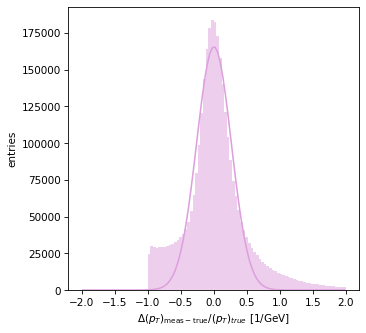

[INFO    ] # of entries: 477217, mean: 0.7106815550905224, std: 10.872017367715712
[INFO    ] gaus fit (a, mu, sig): [2.64733136e+04 6.23976807e-01 6.50957057e+00]


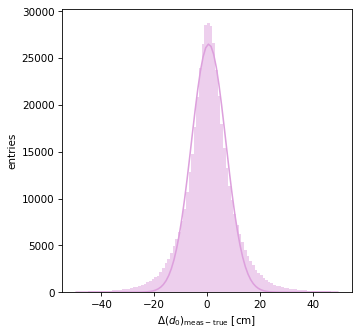

In [4]:
print("MAE as obtained on test dataset:")
k_fold_validation(model = model, 
                  x = x,  
                  y = y, 
                  dxy = dxy, 
                  folds = 1,
                  metric_type="MAE")

print("RMSE as obtained on test dataset:")
k_fold_validation(model = model, 
                  x = x,  
                  y = y, 
                  dxy = dxy, 
                  folds = 1,
                  metric_type = "RMSE")

# Evaluate the quantized resolution
__generate_delta_plots__(model = model,
                        x = x,
                        y = y,
                        dxy = dxy,
                        color = "plum"
                        )

In [ ]:
def create_model(nvariables, 
                 lr=0.001, 
                 clipnorm=10., 
                 initializer = "glorot_uniform",
                 nodes1=64, 
                 nodes2=32, 
                 nodes3=16, 
                 outnodes=2,
                 l1_reg = 0.0, 
                 l2_reg = 0.0):
  
    regularizer = L1L2(l1=l1_reg, l2=l2_reg)
    bn_momentum = 0.9
    eps = 1e-4

    x = x_in = Input((nvariables,))
    x = BatchNormalization(epsilon=eps, momentum=bn_momentum,name="bn-input")(x)
    
    x = Dense(nodes1, 
               kernel_initializer=initializer,
               use_bias = False,
               kernel_regularizer = regularizer,
               name="hidden-dense-1")(x)
    x = BatchNormalization(epsilon = eps, momentum  = bn_momentum, name = "bn-1")(x)
    x = Activation(activation = "tanh",name="act_1")(x)
    
    if nodes2:
    
        x = Dense(nodes2, 
                   kernel_initializer=initializer,
                   use_bias = False,
                   kernel_regularizer = regularizer,
                   name="hidden-dense-2")(x)
        x = BatchNormalization(epsilon = eps, momentum  = bn_momentum, name = "bn-2")(x)
        x = Activation(activation = "tanh",name="act_2")(x)
        if nodes3:

            x = Dense(nodes3, 
                       kernel_initializer=initializer,
                       kernel_regularizer = regularizer,
                       use_bias = False,
                       name="hidden-dense-3")(x)
            x = BatchNormalization(epsilon = eps, momentum  = bn_momentum, name = "bn-3")(x)
            x = Activation(activation = "tanh", name="act_3")(x)

    x = Dense(outnodes,kernel_initializer = initializer,name="dense-output")(x)
    x = Activation("linear")(x)
    
    model = Model(inputs=x_in, outputs=x,name="baseline-model")
    
    adam = Adam(lr=lr, clipnorm=clipnorm)
    model.compile(optimizer=adam, 
                  loss=huber_loss, 
                  metrics=['acc','mse','mae'])
    model.summary()
    
    return model
    

In [ ]:
assert(keras.backend.backend() == 'tensorflow')

normal_epochs = 300
normal_batch_size = 1000
l1_reg = 0.0
l2_reg = 0.0
learning_rate = 0.05
gradient_clip_norm = 100.

lr_decay = LearningRateScheduler(lr_schedule, verbose=1)
terminate_on_nan = TerminateOnNaN()
model_training_checkpoint = ModelCheckpoint(monitor="val_loss", 
                                           verbose = 1,
                                           filepath = "checkpoints/half_baseline_model_ckpt_epoch_{epoch:02d}.hdf5",
                                           period = 10)
early_stopping = EarlyStopping(monitor = "val_loss", 
                                               min_delta= 1e-5, 
                                               mode = "auto", 
                                               patience = 10)

model = create_model(
                    nvariables = NVARIABLES, 
                    lr = learning_rate, 
                    clipnorm = gradient_clip_norm, 
                    nodes1=10, 
                    nodes2=7, 
                    nodes3=5, 
                    outnodes=2,
                    l1_reg = l1_reg, 
                    l2_reg = l2_reg)

logger.info('Training model with l1_reg: {0} l2_reg: {1}'.format(l1_reg, l2_reg))

model, history = train_model(model, 
                      x_train_displ, 
                      np.column_stack((y_train_displ, dxy_train_displ)),
                      save_model=False, 
                      epochs=normal_epochs, 
                      batch_size=normal_batch_size,
                      callbacks=[lr_decay,terminate_on_nan, model_training_checkpoint], 
                      validation_split=0.1, 
                      verbose=True)

metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]]
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(*metrics))

In [ ]:
k_fold_validation(model = model,
                  x = x_test_displ,
                  y = y_test_displ,
                  dxy = dxy_test_displ,
                  folds = 1,
                  metric_type = "RMSE")
k_fold_validation(model = model,
                  x = x_test_displ,
                  y = y_test_displ,
                  dxy = dxy_test_displ,
                  folds = 1,
                  metric_type = "MAE")
__generate_delta_plots__(model,
                         x = x_test_displ,
                         y = y_test_displ,
                         dxy = dxy_test_displ,
                         color = "blue")

In [ ]:
# from nn_pruning_module_support import saving_model
# saving_model(model = model,
#             filepath = "./models",
#             model_filename = "baseline_reduced_dim_0.5")